<a href="https://colab.research.google.com/github/LI3ARA/FYIRP/blob/main/Notebooks/25/VQA_RAG/Googl_colab/soft_prompting/downloading_data_and_formatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Apr 23 14:26:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   47C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installations

In [2]:
!pip install -q torch torchvision
!pip install -q transformers datasets
!pip install -q peft accelerate bitsandbytes
!pip install -q numpy Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 25.6 MB/s eta 0:00:00


## Imports

In [ ]:
# ! pip install -U  fsspec

In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer
import json
from datasets import Dataset
from PIL import Image
from transformers import LlavaForConditionalGeneration, LlavaProcessor, BitsAndBytesConfig
import torch
import json
import os
from peft import LoraConfig, get_peft_model
from huggingface_hub import snapshot_download

In [6]:
import torch
import wandb
import optuna
from transformers import Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig
from transformers import LlavaProcessor, LlavaForConditionalGeneration
from datasets import Dataset
from PIL import Image

## Wandb login

In [7]:
# Initialize wandb
wandb.login()
wandb.init(project="llava-optuna-search")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lisara-20211029 (lisara-20211029-iit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Loading Model

In [8]:
# Define the model (quantized + LoRA)
model_id = "llava-hf/llava-1.5-7b-hf"
processor = LlavaProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

## bitsandbytes config

In [9]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

## Defining functions for training with optuna

In [10]:
def model_init():
    base_model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )
    return get_peft_model(base_model, lora_config)

# Search space for Optuna
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [1, 2]),
        "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 3),
    }

def collate_fn(batch):
    images = [Image.open(item["image"]).convert("RGB") for item in batch]
    texts = [
        f"USER: {item['conversations'][0]['value']} ASSISTANT: {item['conversations'][1]['value']}"
        for item in batch
    ]
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    inputs["labels"] = inputs["input_ids"]
    return inputs



## Loading the datasets

### Downloading images and and unzipping the folder

In [11]:
from huggingface_hub import snapshot_download

# Download the entire dataset to '/content/spiqa'
snapshot_download(
    repo_id="google/spiqa",
    repo_type="dataset",
    local_dir='/content/spiqa',
    allow_patterns="train_val/SPIQA_train_val_Images.zip"  # Only download this file
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

SPIQA_train_val_Images.zip:   0%|          | 0.00/32.0G [00:00<?, ?B/s]

'/content/spiqa'

In [ ]:
import zipfile, os

zip_path = "/content/spiqa/train_val/SPIQA_train_val_Images.zip"
extract_path = "/content/spiqa/spiqa_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


### Loading the LoRA structured training dataset

In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_sample.json", "r") as f:
    dataset_train_json = json.load(f)

In [ ]:
len(dataset_train_json)

### Convert to huggingface dataset

In [ ]:
dataset_train = Dataset.from_list(dataset_train_json)

## Training arguments defining

In [ ]:
# TrainingArguments (will be updated by Optuna trial)
training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora-optuna",
    logging_steps=10,
    save_steps=50,
    save_strategy="steps",
    eval_steps=50,
    evaluation_strategy="steps",
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="wandb",
    fp16=True,
    remove_unused_columns=False,
    save_total_limit=2,
    label_names=["labels"],
)


### Define trainer and Run the optuna search

In [ ]:
#  Define trainer
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset_train,
    data_collator=collate_fn,
)

#  Run Optuna search
best_run = trainer.hyperparameter_search(
    direction="minimize",
    n_trials=5,  # Keep this low on Colab
    hp_space=hp_space,
    compute_objective=lambda metrics: metrics["eval_loss"],
)

# Print Best Run
print("Best Trial:")
print(best_run)


In [ ]:
# Download the entire dataset to '/content/spiqa'
snapshot_download(
    repo_id="google/spiqa",
    repo_type="dataset",
    local_dir='/content/spiqa',
    allow_patterns="train_val/SPIQA_train_val_Images.zip"  # Only download this file
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

SPIQA_train_val_Images.zip:   0%|          | 0.00/32.0G [00:00<?, ?B/s]

'/content/spiqa'

In [ ]:
# 4. Unzip relevant data
import zipfile, os

zip_path = "/content/spiqa/train_val/SPIQA_train_val_Images.zip"
extract_path = "/content/spiqa/spiqa_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import json
import os

with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json", "r") as f:
    converted = json.load(f)

In [ ]:
old_prefix = "/content/spiqa/spiqa_images/SPIQA_train_val_Images"
new_prefix = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images"


# Update paths
for d in converted:
    if d['image'].startswith(old_prefix):
        d['image'] = d['image'].replace(old_prefix, new_prefix, 1)

# Preview result
for d in converted[:2]:
    print(d['image'])

/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png
/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Table1-1.png


In [ ]:
import os

def find_file(root_dir, filename):
  for dirpath, dirnames, filenames in os.walk(root_dir):
    if filename in filenames:
      return os.path.join(dirpath, filename)
  return None

path = find_file("/content/", "1612.01810v3-Figure6-1.png")
print(path)

/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png


In [ ]:
dataset = Dataset.from_list(converted)

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    use_fast = True
)

In [ ]:
dataset[0]

{'id': '1612.01810v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich method converges faster, joint or separate assignment and update steps?'},
  {'from': 'gpt',
   'value': 'The joint method converges faster than the separate method.'}]}

In [ ]:
model_id = "llava-hf/llava-1.5-7b-hf"  # 7B for Colab T4
processor = LlavaProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",

)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
lora_config = LoraConfig(
    r=8,  # Rank
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # Key attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # ~0.1% params

trainable params: 4,980,736 || all params: 7,068,407,808 || trainable%: 0.0705


In [ ]:
def collate_fn(batch):
    images = [Image.open(item["image"]).convert("RGB") for item in batch]
    texts = [
        f"USER: {item['conversations'][0]['value']} ASSISTANT: {item['conversations'][1]['value']}"
        for item in batch
    ]
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    # Enable loss computation!
    inputs["labels"] = inputs["input_ids"].clone()
    return inputs

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


In [ ]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=50,
    fp16=True,
    remove_unused_columns=False,
    label_names=["labels"],  # Specifies that "labels" will be the label input in the model
    # evaluation_strategy="steps",  # Evaluate the model every `eval_steps` steps
    save_strategy="steps",  # Save model weights every `save_steps` steps
    eval_steps=50,  # Evaluate the model every 50 steps
    # load_best_model_at_end=True,  # Automatically load the best model based on evaluation
    metric_for_best_model="loss",  # Track loss to determine the best model
    greater_is_better=False,  # We want a lower loss, so False is correct
    save_total_limit=2,  # Keep only the 2 latest saved models
)

print(training_args)


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=50,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_object=False,
fp

In [ ]:
!pip install --upgrade --no-cache-dir transformers

In [ ]:
from transformers import TrainingArguments, Trainer
import wandb

wandb.login()  # only once per machine or runtime
wandb.init(project="my-llava-finetune")  # optional, but useful

# Define training arguments
training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=50,
    fp16=True,
    remove_unused_columns=False,
    label_names=["labels"],  # Specifies that "labels" will be the label input in the model
    # evaluation_strategy="steps",  # Evaluate the model every `eval_steps` steps
    save_strategy="steps",  # Save model weights every `save_steps` steps
    eval_steps=50,  # Evaluate the model every 50 steps
    # load_best_model_at_end=True,  # Automatically load the best model based on evaluation
    metric_for_best_model="loss",  # Track loss to determine the best model
    greater_is_better=False,  # We want a lower loss, so False is correct
    save_total_limit=2,  # Keep only the 2 latest saved models
)
print(training_args)

# Initialize trainer with the defined arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn,
    # eval_dataset=val_dataset,  # Uncomment if you have a validation dataset
)

# Start training
trainer.train()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Step,Training Loss
10,48.233300
20,29.462300
30,18.095600
40,16.634200
50,15.897400
60,15.478000
70,15.106800
80,14.984800
90,14.865500
100,14.814100


KeyboardInterrupt: 

Training Loss Trend:

The loss starts very high (48.23) but drops rapidly in the first few steps, indicating the model is quickly learning from the initial data.

By step 30, the loss is down to ~18.09, showing good early progress.

After step 50, the loss stabilizes around 14.6–15.8, suggesting the model is now fine-tuning rather than making big leaps.

Convergence Behavior:

The loss is still decreasing slowly (14.81 → 14.69 between steps 100–160), meaning the model is still improving, but gains are marginal.

There’s some fluctuation (e.g., 14.69 → 14.75 around step 150), which could be due to noisy data or a high learning rate.

Training Speed:

0.25 iterations/sec is relatively slow—this could be due to hardware constraints (e.g., a single GPU) or a large batch size.

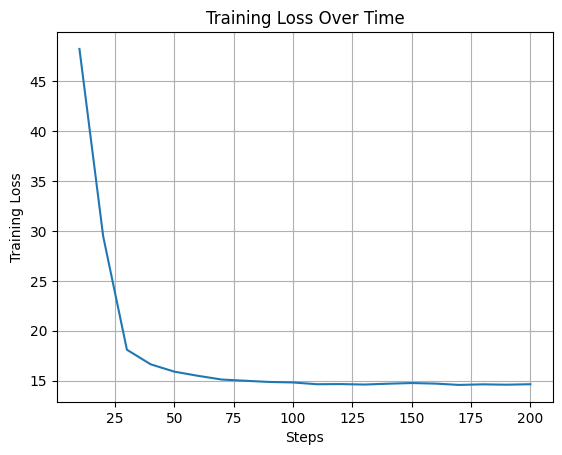

In [ ]:
def lot_loss(trainer):
  # If training is interrupted, and you have access to the `trainer` object
  loss_history = trainer.state.log_history

  # Extract steps and loss
  steps = [log['step'] for log in loss_history if 'loss' in log]
  losses = [log['loss'] for log in loss_history if 'loss' in log]

  # Plot
  import matplotlib.pyplot as plt

  plt.plot(steps, losses)
  plt.xlabel("Steps")
  plt.ylabel("Training Loss")
  plt.title("Training Loss Over Time")
  plt.grid(True)
  plt.show()


In [ ]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
class LiveLossPlotCallback(TrainerCallback):
    def __init__(self):
        self.steps = []
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        # Only plot when there's a loss logged
        if "loss" in logs:
            self.steps.append(state.global_step)
            self.losses.append(logs["loss"])

            # Live plot
            if state.global_step % 50 == 0:
                clear_output(wait=True)
                plt.plot(self.steps, self.losses)
                plt.xlabel("Steps")
                plt.ylabel("Loss")
                plt.title("Training Progress")
                plt.grid(True)
                plt.show()


NameError: name 'TrainerCallback' is not defined

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn,
    callbacks=[LiveLossPlotCallback()],
)

In [ ]:
# Run this FIRST (before any imports)
!pip install --force-reinstall numpy==1.23.5
!pip install --force-reinstall torch==2.0.1 torchvision==0.15.2 transformers==4.30.2
!pip install --force-reinstall datasets==2.13.1 peft==0.4.0 accelerate==0.20.3
!pip install --force-reinstall bitsandbytes==0.40.2 Pillow==9.5.0
# !pip install -q git+https://github.com/haotian-liu/LLaVA.git@main  # LLaVA main branch

# Verify installations
!pip list | grep -E "torch|transformers|datasets|peft|bitsandbytes|numpy"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 100.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 whi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.7 MB/s eta 0:00:00
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 7.2 MB/s eta 0:00:00
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-3.4.1-cp311-cp311-ma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 116.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.6.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


bitsandbytes                          0.40.2
datasets                              2.13.1
numpy                                 2.2.5
peft                                  0.4.0
sentence-transformers                 3.4.1
tensorflow-datasets                   4.9.8
torch                                 2.6.0
torchaudio                            2.6.0+cu124
torchsummary                          1.5.1
torchvision                           0.15.2
transformers                          4.51.3
vega-datasets                         0.9.0


In [ ]:
import numpy as np
print(np.__version__)  # Must show '1.23.5'
assert hasattr(np, 'dtype')  # Check critical attribute

2.2.5


In [ ]:
!apt-get update
!apt-get install cuda-toolkit-11-8
import os
os.environ["LD_LIBRARY_PATH"] += ":" + "/usr/local/cuda-11/lib64"
os.environ["LD_LIBRARY_PATH"] += ":" + "/usr/local/cuda-11.8/lib64"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,604 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,150 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/mai

In [ ]:
!pip install datasets==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.13.1
    Uninstalling datasets-2.13.1:
      Successfully uninstalled datasets-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.10.0 which is incompatible.


In [ ]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-qn7h257w
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-qn7h257w
  Resolved https://github.com/huggingface/transformers to commit 4f9893cbbc556c7c27b42bdc64fc271f7b1a0218
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.9 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.52.0.dev0-py3-none-any.whl size=11450530 sha256=156687f325c1da94f1b3c041d7bda89ca6a5a647ecc36e5cea40b226c1244881
  Stored in directory: /tmp/pip-ephem-wheel-cache-r3biscnw/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully 

In [ ]:
! pip install -U transformers

In [ ]:
# from transformers import Qwen2VLForConditionalGeneration
# from transformers import Qwen2VLProcessor
from transformers import BitsAndBytesConfig

ImportError: cannot import name 'is_jinja_available' from 'transformers.utils.import_utils' (/usr/local/lib/python3.11/dist-packages/transformers/utils/import_utils.py)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
import torch



AttributeError: module 'numpy' has no attribute 'dtypes'

# SPIQA dataset

In [ ]:
from huggingface_hub import snapshot_download

# Download the entire dataset to '/content/spiqa'
snapshot_download(
    repo_id="google/spiqa",
    repo_type="dataset",
    local_dir='/content/spiqa',
    allow_patterns="train_val/SPIQA_train_val_Images.zip"  # Only download this file
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

SPIQA_train_val_Images.zip:   0%|          | 0.00/32.0G [00:00<?, ?B/s]

'/content/spiqa'

In [ ]:
# 4. Unzip relevant data
import zipfile, os

zip_path = "/content/spiqa/train_val/SPIQA_train_val_Images.zip"
extract_path = "/content/spiqa/spiqa_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# 5. Load and convert SPIQA_train.json to LLaVA format
import json
import os

with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_val/SPIQA_train.json", "r") as f:
    spiqa_data = json.load(f)


In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_val/SPIQA_val.json", "r") as f:
    spiqa_val_data = json.load(f)

In [ ]:
spiqa_test_data_df = pd.read_csv("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa.csv")

In [ ]:
spiqa_test_data_df.head(3)

,q_id,doc_id,old_question,answer,doc_path,documents,rationale,reference_figure,paper_title,paper_abstract,caption,question
0,spiqa_0,1805.01216v3,How does Figure 9 in the paper *Disentangling ...,\n\nThe pre-processed SMD Navigate data combi...,1805.01216v3.pdf,"['1805.01216v3.pdf', '1705.09296v2.pdf', '1705...",\n\nThe figure shows two tables. The top tabl...,1805.01216v3-Figure9-1.png,Disentangling Language and Knowledge in Task-O...,The Knowledge Base (KB) used for real-world ap...,Figure 9: Pre-processing of SMD Navigate data ...,\n\nWhat is the difference between the origin...
1,spiqa_1,1805.07567v2,Referring to the figure that illustrates the i...,\n\nIncreasing the value of β2 decreases the ...,1805.07567v2.pdf,"['1805.07567v2.pdf', '1802.07222v1.pdf', '1811...",\n\nThe figure shows that the precision curve...,1805.07567v2-Figure6-1.png,Optimizing the F-measure for Threshold-free Sa...,Current CNN-based solutions to salient object ...,"Precision, Recall, F-measure of model trained ...",\n\nWhat is the effect of increasing the valu...
2,spiqa_2,1603.00286v5,How does Figure 1 in the paper illustrate the ...,"\n\nIn 2-D division, there may be unallocated...",1603.00286v5.pdf,"['1603.00286v5.pdf', '1705.07164v8.pdf', '1811...",\n\nFigure 1 shows an example of a 2-D cake w...,1603.00286v5-Figure1-1.png,Redividing the Cake,The paper considers fair allocation of resourc...,"Fig. 1 With geometric constraints, an efficien...",\n\nWhy does the author state that there is a...


In [ ]:
spiqa_data['2307.11618v1'].keys()

dict_keys(['paper_id', 'all_figures', 'qa'])

In [ ]:
spiqa_data['2307.11618v1']['qa'][0]

{'question': 'Which method performs the best on the DomainNet dataset with a labeling budget of 5k?',
 'answer': 'DiaNA (Ours)',
 'explanation': 'The table shows the accuracy of different methods on the DomainNet dataset with different labeling budgets. DiaNA (Ours) achieves the highest accuracy of 57.8% with a labeling budget of 5k.',
 'reference': '2307.11618v1-Table1-1.png'}

In [ ]:
spiqa_data['2307.11618v1']['all_figures'].keys()

dict_keys(['2307.11618v1-Table1-1.png', '2307.11618v1-Table2-1.png', '2307.11618v1-Figure2-1.png', '2307.11618v1-Table5-1.png', '2307.11618v1-Figure6-1.png', '2307.11618v1-Figure7-1.png', '2307.11618v1-Figure4-1.png', '2307.11618v1-Table3-1.png', '2307.11618v1-Figure3-1.png', '2307.11618v1-Figure5-1.png', '2307.11618v1-Table4-1.png'])

In [ ]:
spiqa_data['2307.11618v1']['all_figures']['2307.11618v1-Table1-1.png']

{'caption': ' Comparison results (Accuracy: %) on DomainNet with 1k, 2k and 5k labeling budgets. “Random” and “CONF” correspond to the classic AL approaches “Random Sampling” and “Least-Confidence Sampling”.',
 'content_type': 'table',
 'figure_type': 'table'}

In [ ]:
# import json
# import os

# # Load SPIQA data (update path as needed)
# with open("/content/spiqa/train_val/SPIQA_train.json", "r") as f:
#     spiqa_data = json.load(f)
def convert_to_lora_dataset(spiqa_data):
  converted = []
  image_base_path = "/content/spiqa/spiqa_images/SPIQA_train_val_Images"  # Where the images were extracted

  # Iterate through each paper
  for paper_id, paper in spiqa_data.items():
      figures = paper.get("all_figures", {})
      qa_pairs = paper.get("qa", [])

      # print("Nu of qa pairs:", (qa_pairs))

      for qa in qa_pairs:
          ref_img = qa.get("reference")
          question = qa.get("question")
          answer = qa.get("answer")

          if not ref_img or ref_img not in figures:
              continue

          image_path = os.path.join(image_base_path, paper_id, ref_img)
          if not os.path.exists(image_path):
            # print('path does not exist', image_path)
            continue

          # Add to LLaVA-style format
          converted.append({
              "id": paper_id,
              "image": image_path,
              "conversations": [
                  {
                      "from": "human",
                      "value": f"<image>\n{question}"
                  },
                  {
                      "from": "gpt",
                      "value": answer
                  }
              ]
          })
  return converted


In [ ]:
import os

def find_file(root_dir, filename):
  for dirpath, dirnames, filenames in os.walk(root_dir):
    if filename in filenames:
      return os.path.join(dirpath, filename)
  return None

path = find_file("/content", "2310.15484v1-Table5-1.png")

In [ ]:
path

'/content/spiqa/spiqa_images/SPIQA_train_val_Images/2310.15484v1/2310.15484v1-Table5-1.png'

In [ ]:
len(converted)

262524

In [ ]:
converted_val = convert_to_lora_dataset(spiqa_val_data)

In [ ]:
converted_val[0]

{'id': '1612.01810v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich method converges faster, joint or separate assignment and update steps?'},
  {'from': 'gpt',
   'value': 'The joint method converges faster than the separate method.'}]}

In [ ]:
converted_test_list = []
df = spiqa_test_data_df.copy()

for _, row in df.iterrows():
    paper_id = row['doc_id']
    image_path = "/content/spiqa/spiqa_images/SPIQA_train_val_Images/"+row['reference_figure']  # or some logic to resolve full image path
    question = row['old_question']
    answer = row['answer']

    converted_test_list.append({
        "id": paper_id,
        "image": image_path,
        "conversations": [
            {
                "from": "human",
                "value": f"<image>\n{question}"
            },
            {
                "from": "gpt",
                "value": answer
            }
        ]
    })

# Optional: print or save to JSON
import json
with open('/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_test_converted.json', 'w') as f:
    json.dump(converted_test_list, f, indent=2)


In [ ]:
output_path = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json"
with open(output_path, "w") as f:
    json.dump(converted, f, indent=2)

print(f" Converted dataset saved to: {output_path}")

 Converted dataset saved to: /content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json


In [ ]:
import json
import os

with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_train_converted.json", "r") as f:
    converted_train = json.load(f)

In [ ]:
with open("/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/SPIQA_test_converted.json", "r") as f:
    converted_test = json.load(f)

In [ ]:
converted_val = convert_to_lora_dataset(spiqa_val_data)

In [ ]:
converted_train[0]

{'id': '1612.01810v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich method converges faster, joint or separate assignment and update steps?'},
  {'from': 'gpt',
   'value': 'The joint method converges faster than the separate method.'}]}

In [ ]:
converted_val[0]

{'id': '1705.08868v2',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1705.08868v2/1705.08868v2-Table1-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhich objective function resulted in the highest MODE score?'},
  {'from': 'gpt', 'value': 'ADV'}]}

In [ ]:
converted_test[0]

{'id': '1805.01216v3',
 'image': '/content/spiqa/spiqa_images/SPIQA_train_val_Images/1805.01216v3-Figure9-1.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nHow does Figure 9 in the paper *Disentangling Language and Knowledge in Task-Oriented Dialogs* illustrate the transformation of point-of-interest properties between the original and pre-processed SMD Navigate datasets?'},
  {'from': 'gpt',
   'value': ' \n\nThe pre-processed SMD Navigate data combines all the properties (such as distance, address) of a point of interest (POI) into a single subject with the object being "poi". The original data had separate entries for each property. '}]}

In [ ]:
!pip3 install bitsandbytes peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.13.1
    Uninstalling datasets-2.13.1:
      Successfully uninstalled datasets-2.13.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 

In [ ]:
import numpy as np
import sys

# Fix for numpy.dtypes missing
if not hasattr(np, 'dtypes'):
    np.dtypes = np._DTypeMeta
    sys.modules['numpy.dtypes'] = np.dtypes

# Now import transformers
from transformers import LlavaForConditionalGeneration, LlavaProcessor, BitsAndBytesConfig

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
# Save your file to Drive
!cp -r /content/spiqa/ /content/drive/MyDrive/
# Optionally copy saved files back
!cp -r /content/drive/MyDrive/spiqa/ /content/spiqa/

In [ ]:
!python -m bitsandbytes

False

===================================BUG REPORT===================================
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/python3.11/dist-packages/cv2/../../lib64')}
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /usr/local/lib/python3.11/dist-packages/cv2/../../lib64:/usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http')

In [ ]:
import torch
from transformers import LlavaForConditionalGeneration, LlavaProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import json
from PIL import Image

False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/python3.11/dist-packages/cv2/../../lib64')}
The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-l4-s-2oss8z7urz1cx --tunnel_background_save_delay=10s --tunnel_periodic_background_save_frequency=30m0s --enable_output_coalescing=true --output_coalescing_required=true '), PosixPath('--logtostderr --listen_host=172.28.0.12 --target_host=172.28.0.12 --tunnel_background_save_url=htt

/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /usr/local/lib/python3.11/dist-packages/cv2/../../lib64:/usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/peft/__init__.py:22 in <module>                          │
│                                                                                                  │
│   19                                                                                             │
│   20 __version__ = "0.4.0"                                                                       │
│   21                                                                                             │
│ ❱ 22 from .auto import (                                                                         │
│   23 │   AutoPeftModel,                                                                          │
│   24 │   AutoPeftModelForCausalLM,                                                               │
│   25 │   AutoPeftModelForSequenceClassification,                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/peft/auto.py:30 in <module>                              │
│                                                                                                  │
│    27 │   AutoModelForTokenClassification,                                                       │
│    28 )                                                                                          │
│    29                                                                                            │
│ ❱  30 from .mapping import MODEL_TYPE_TO_PEFT_MODEL_MAPPING                                      │
│    31 from .peft_model import (                                                                  │
│    32 │   PeftModel,                                                                             │
│    33 │   PeftModelForCausalLM,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/peft/mapping.py:20 in <module>                           │
│                                                                                                  │
│   17                                                                                             │
│   18 from typing import TYPE_CHECKING, Any, Dict                                                 │
│   19                                                                                             │
│ ❱ 20 from .peft_model import (                                                                   │
│   21 │   PeftModel,                                                                              │
│   22 │   PeftModelForCausalLM,                                                                   │
│   23 │   PeftModelForFeatureExtraction,                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/peft/peft_model.py:39 in <module>                        │
│                                                                                                  │
│     36 from transformers.utils import PushToHubMixin                                             │
│     37                                                                                           │
│     38 from . import __version__                                                                 │
│ ❱   39 from .tuners import (                                                                     │
│     40 │   AdaLoraModel,                                   

In [ ]:
import pandas as pd

In [ ]:
#  SPIQA to LLaVA LoRA Fine-Tuning Pipeline (Colab Ready)
from google.colab import drive

# Disconnect any existing mounts (optional)
!fusermount -u /content/drive

# Mount the secondary Google Drive
drive.mount('/content/drive')

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


In [ ]:
# 2. Install required libraries
! datasets huggingface_hub
# !git clone https://github.com/haotian-liu/LLaVA.git
# %cd LLaVA
# !pip install -e .

/bin/bash: line 1: datasets: command not found


In [ ]:
#  3. Download SPIQA dataset from Hugging Face
from huggingface_hub import snapshot_download
# snapshot_download(repo_id="google/spiqa", repo_type="dataset", local_dir='/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa')

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/8.60k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

SPIQA_testA.json:   0%|          | 0.00/778k [00:00<?, ?B/s]

SPIQA_testA_Images_224px.zip:   0%|          | 0.00/47.1M [00:00<?, ?B/s]

SPIQA_train_val_test-A_raw_tex.zip:   0%|          | 0.00/440M [00:00<?, ?B/s]

(…)rain_val_test-A_extracted_paragraphs.zip:   0%|          | 0.00/321M [00:00<?, ?B/s]

SPIQA_testA_Images.zip:   0%|          | 0.00/121M [00:00<?, ?B/s]

SPIQA_testB.json:   0%|          | 0.00/3.96M [00:00<?, ?B/s]

SPIQA_testB_Images.zip:   0%|          | 0.00/196M [00:00<?, ?B/s]

example.json:   0%|          | 0.00/103 [00:00<?, ?B/s]

SPIQA_testB_Images_224px.zip:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

SPIQA_testC.json:   0%|          | 0.00/9.29M [00:00<?, ?B/s]

SPIQA_testC_Images.zip:   0%|          | 0.00/112M [00:00<?, ?B/s]

SPIQA_testC_Images_224px.zip:   0%|          | 0.00/63.3M [00:00<?, ?B/s]

SPIQA_train.json:   0%|          | 0.00/209M [00:00<?, ?B/s]

testA_data_viewer.json:   0%|          | 0.00/2.89M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:752: UserWarning: Not enough free disk space to download the file. The expected file size is: 32023.84 MB. The target location /content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/.cache/huggingface/download/train_val only has 15717.48 MB free disk space.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:752: UserWarning: Not enough free disk space to download the file. The expected file size is: 32023.84 MB. The target location /content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/train_val only has 15717.48 MB free disk space.
  warnings.warn(


SPIQA_train_val_Images.zip:   0%|          | 0.00/32.0G [00:00<?, ?B/s]

SPIQA_val.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

'/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa'



---



In [ ]:
old_prefix = "/content/spiqa/spiqa_images/SPIQA_train_val_Images"
new_prefix = "/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images"


# Update paths
for d in converted:
    if d['image'].startswith(old_prefix):
        d['image'] = d['image'].replace(old_prefix, new_prefix, 1)

# Preview result
for d in converted[:2]:
    print(d['image'])

/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Figure6-1.png
/content/drive/MyDrive/FYPIRP_COLAB_DATA/spiqa/spiqa_images/SPIQA_train_val_Images/1612.01810v3/1612.01810v3-Table1-1.png




---



##  Create a Hugging Face Dataset
Convert the processed data into a dataset for training:

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.23.5  # Version known to work with datasets
!pip install --upgrade datasets

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 112.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
chex

^C


In [ ]:
from datasets import Dataset


In [ ]:
# Convert to Hugging Face Dataset
dataset = Dataset.from_list(converted)

## Custom Data Collector for LLaVa

In [ ]:
from PIL import Image
from transformers import default_data_collator


AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:

def collate_fn(batch):
    images = [Image.open(item["image"]).convert("RGB") for item in batch]
    texts = []
    for item in batch:
        # Extract human/GPT turns
        human_turn = item["conversations"][0]["value"]  # "<image>\nQuestion"
        gpt_turn = item["conversations"][1]["value"]     # "Answer"
        # Format for LLaVA (USER: <image>\nQuestion ASSISTANT: Answer)
        text = f"USER: {human_turn} ASSISTANT: {gpt_turn}"
        texts.append(text)

    # Process images and texts together
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    return inputs

# Example batch
batch = [dataset[0], dataset[1]]
collate_fn(batch)  # Test if it works



---



In [ ]:
# ====== 1. Load Model (4-bit quantized) ======
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model_id = "llava-hf/llava-1.5-7b-hf"
processor = LlavaProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

In [ ]:
# ====== 2. Apply LoRA ======
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

In [ ]:
# ====== 3. Load Your JSON Data ======
with open("spiqa_converted.json", "r") as f:
    data = json.load(f)  # Your formatted data

dataset = load_dataset("json", data_files={"train": "spiqa_converted.json"})["train"]

In [ ]:
# ====== 4. Data Collator ======
def collate_fn(batch):
    images = [Image.open(item["image"]).convert("RGB") for item in batch]
    texts = [
        f"USER: {item['conversations'][0]['value']} ASSISTANT: {item['conversations'][1]['value']}"
        for item in batch
    ]
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    return inputs

In [ ]:
# ====== 5. Training ======
training_args = TrainingArguments(
    output_dir="./llava-spiqa-lora",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=5,
    save_steps=50,
    fp16=True,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn,
)

trainer.train()

In [ ]:
# ====== 6. Save Model ======
model.save_pretrained("./llava-spiqa-lora")

In [ ]:
# Key Stability Features
# Version Locking: All critical libraries pinned to known stable versions.

# 4-bit Quantization: Reduces memory usage for Colab's T4 GPU.